**Setup LunarLander-v3 environment**

In [1]:
!pip install swig
!pip install box2d gymnasium[box2d]



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 67.3 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp312-cp312-linux_x86_64.whl size=2409540 sha256=a8d88943149405b4c067447b60eaeecc139198f5e423e69cd36314284a60de68
  Stored in directory: /root/.cache/pip/wheels/2a/e9/60/774da0bcd07f7dc7761a8590fa2d065e4069568e78dcdc3318
Successfully built box2d-py


In [3]:
import numpy as np
import torch
import gymnasium as gym



In [4]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [5]:
env = gym.make("LunarLander-v3")

obs, info = env.reset(seed=SEED)

print("Observation shape:", np.shape(obs))     # expected: (8,)
print("First observation sample:", obs)
print("Action space (n):", env.action_space.n) # expected: 4

# Take one random step to verify API works
a = env.action_space.sample()
next_obs, reward, terminated, truncated, info = env.step(a)
done = terminated or truncated
print("Step => reward:", reward, "| done:", done)


Observation shape: (8,)
First observation sample: [ 0.00229702  1.4181306   0.2326471   0.3204666  -0.00265488 -0.05269805
  0.          0.        ]
Action space (n): 4
Step => reward: 1.1449803922348565 | done: False


**Build the Q-Network**

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class QNetwork(nn.Module):
    def __init__(self, state_dim=8, action_dim=4, hidden_dim=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32)  # ensure tensor
        if x.ndim == 1:
            x = x.unsqueeze(0)  # add batch dim
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # outputs Q-values for each action

*Quick test QNetwork*

In [8]:
# Test QNetwork
test_net = QNetwork()
sample_state = np.random.randn(8)  # fake observation
q_values = test_net(sample_state)

print("Q-values for sample state:", q_values.detach().numpy())


Q-values for sample state: [[ 0.02892792 -0.11966199 -0.05584957  0.18264405]]


Replay Buffer

In [9]:
from collections import deque
import random

In [10]:
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.tensor(states, dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_states, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)

Quick test Replay Buffer

In [11]:
# Test ReplayBuffer
buffer = ReplayBuffer(capacity=10)

# Push some fake transitions
for i in range(5):
    buffer.push(np.random.randn(8), np.random.randint(0,4), np.random.randn(),
                np.random.randn(8), np.random.choice([0,1]))

print("Buffer size:", len(buffer))

# Sample a minibatch
states, actions, rewards, next_states, dones = buffer.sample(3)
print("Sampled states shape:", states.shape)
print("Sampled actions:", actions)


Buffer size: 5
Sampled states shape: torch.Size([3, 8])
Sampled actions: tensor([3, 0, 2])


/tmp/ipython-input-3686808929.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  torch.tensor(states, dtype=torch.float32),


DQN Agent

In [12]:
import torch.optim as optim

In [13]:
class DQNAgent:
    def __init__(self, state_dim=8, action_dim=4, hidden_dim=128,
                 lr=1e-3, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995,
                 buffer_capacity=100000, batch_size=64, target_update_freq=1000):

        # Networks
        self.q_online = QNetwork(state_dim, action_dim, hidden_dim)
        self.q_target = QNetwork(state_dim, action_dim, hidden_dim)
        self.q_target.load_state_dict(self.q_online.state_dict())  # copy weights

        self.optimizer = optim.Adam(self.q_online.parameters(), lr=lr)

        # Replay buffer
        self.replay_buffer = ReplayBuffer(capacity=buffer_capacity)
        self.batch_size = batch_size

        # Discount factor
        self.gamma = gamma

        # Epsilon-greedy params
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

        # Training step counter for target updates
        self.learn_step_counter = 0
        self.target_update_freq = target_update_freq

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:  # explore
            return np.random.randint(0, 4)
        else:  # exploit
            q_values = self.q_online(state).detach().numpy()
            return np.argmax(q_values)

    def remember(self, state, action, reward, next_state, done):
        self.replay_buffer.push(state, action, reward, next_state, done)

    def replay(self):
        if len(self.replay_buffer) < self.batch_size:
            return None  # not enough samples

        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

        # Compute Q(s,a)
        q_values = self.q_online(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Compute target Q
        with torch.no_grad():
            max_next_q = self.q_target(next_states).max(1)[0]
            target_q = rewards + self.gamma * max_next_q * (1 - dones)

        # Loss
        loss = F.mse_loss(q_values, target_q)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target net periodically
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_freq == 0:
            self.q_target.load_state_dict(self.q_online.state_dict())

        # Decay epsilon
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

        return loss.item()

Quick test DQNAgent

In [14]:
# Test agent
agent = DQNAgent()

# Fake state
state = np.random.randn(8)
action = agent.choose_action(state)
print("Chosen action:", action)

# Store fake transition and train
agent.remember(state, action, 1.0, np.random.randn(8), False)
loss = agent.replay()
print("Loss (None if < batch size):", loss)


Chosen action: 2
Loss (None if < batch size): None


Training Loop

In [15]:
import matplotlib.pyplot as plt


In [16]:
def train_dqn(env, agent, episodes=500, max_steps=1000):
    rewards_history = []
    epsilon_history = []
    loss_history = []

    for ep in range(episodes):
        state, info = env.reset(seed=None)
        total_reward = 0
        for step in range(max_steps):
            # Choose action
            action = agent.choose_action(state)

            # Take step
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Store transition
            agent.remember(state, action, reward, next_state, done)

            # Train from replay
            loss = agent.replay()
            if loss is not None:
                loss_history.append(loss)

            state = next_state
            total_reward += reward

            if done:
                break

        rewards_history.append(total_reward)
        epsilon_history.append(agent.epsilon)

        # Print progress every 20 episodes
        if (ep+1) % 20 == 0:
            avg_reward = np.mean(rewards_history[-20:])
            print(f"Episode {ep+1}, Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.3f}")

    return rewards_history, epsilon_history, loss_history

Run Training

In [17]:
env = gym.make("LunarLander-v3")
agent = DQNAgent()

rewards, epsilons, losses = train_dqn(env, agent, episodes=200)


/tmp/ipython-input-3314194077.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)  # ensure tensor


Episode 20, Avg Reward: -328.12, Epsilon: 0.010
Episode 40, Avg Reward: -227.79, Epsilon: 0.010
Episode 60, Avg Reward: -191.48, Epsilon: 0.010
Episode 80, Avg Reward: -144.11, Epsilon: 0.010
Episode 100, Avg Reward: -123.83, Epsilon: 0.010
Episode 120, Avg Reward: -90.94, Epsilon: 0.010
Episode 140, Avg Reward: -66.30, Epsilon: 0.010
Episode 160, Avg Reward: -63.55, Epsilon: 0.010
Episode 180, Avg Reward: -140.94, Epsilon: 0.010
Episode 200, Avg Reward: -103.27, Epsilon: 0.010


Plot Results

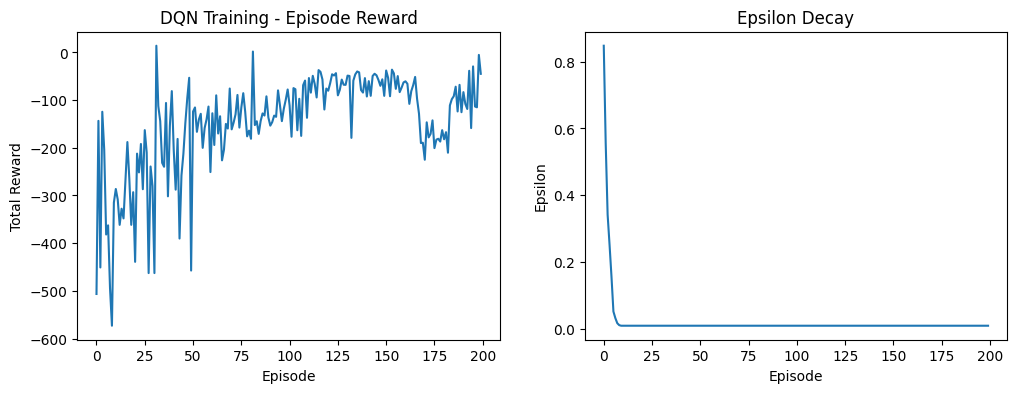

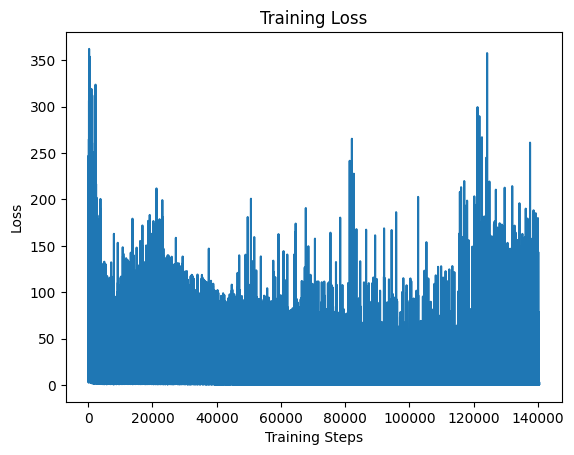

In [18]:
# Plot Episode Reward
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training - Episode Reward")

# Plot Epsilon Decay
plt.subplot(1,2,2)
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")

plt.show()

# (Optional) Plot Loss
if len(losses) > 0:
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()


Baseline WITHOUT replay & target

In [19]:
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [20]:


class OnlineOnlyAgent:
    """DQN-style function approximator WITHOUT replay and WITHOUT target net."""
    def __init__(self, state_dim=8, action_dim=4, hidden_dim=128,
                 lr=1e-3, gamma=0.99,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        self.q = QNetwork(state_dim, action_dim, hidden_dim)
        self.opt = optim.Adam(self.q.parameters(), lr=lr)
        self.gamma = gamma

        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, 4)
        with torch.no_grad():
            q_vals = self.q(state)
            return int(torch.argmax(q_vals, dim=1).item())

    def step_update(self, state, action, reward, next_state, done):
        # Q(s,a)
        s = torch.tensor(state, dtype=torch.float32)
        ns = torch.tensor(next_state, dtype=torch.float32)
        q_sa = self.q(s).squeeze(0)[action]

        # Target: r + γ max_a' Q(s',a')
        with torch.no_grad():
            max_next = self.q(ns).max(1)[0].squeeze(0)
            target = torch.tensor(reward, dtype=torch.float32) + (0 if done else self.gamma * max_next)

        loss = F.mse_loss(q_sa, target)

        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

        # decay epsilon (episode-level decay is also fine; this is per-step)
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

        return float(loss.item())


Train the online-only agent (no replay/target)

In [21]:
def train_online_only(env, agent, episodes=200, max_steps=1000):
    rewards_hist, eps_hist, loss_hist = [], [], []
    for ep in range(episodes):
        state, info = env.reset()
        total = 0.0
        for t in range(max_steps):
            a = agent.choose_action(state)
            next_state, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated

            loss = agent.step_update(state, a, r, next_state, done)
            loss_hist.append(loss)

            total += r
            state = next_state
            if done:
                break

        rewards_hist.append(total)
        eps_hist.append(agent.epsilon)

        if (ep+1) % 20 == 0:
            print(f"[NoReplay/NoTarget] Ep {ep+1}: avgR={np.mean(rewards_hist[-20:]):.2f}, eps={agent.epsilon:.3f}")

    return rewards_hist, eps_hist, loss_hist

# Run baseline training
env_baseline = gym.make("LunarLander-v3")
baseline_agent = OnlineOnlyAgent()
rewards_base, eps_base, loss_base = train_online_only(env_baseline, baseline_agent, episodes=200)


/tmp/ipython-input-3314194077.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)  # ensure tensor


[NoReplay/NoTarget] Ep 20: avgR=-204.92, eps=0.010
[NoReplay/NoTarget] Ep 40: avgR=-153.81, eps=0.010
[NoReplay/NoTarget] Ep 60: avgR=-136.51, eps=0.010
[NoReplay/NoTarget] Ep 80: avgR=-165.40, eps=0.010
[NoReplay/NoTarget] Ep 100: avgR=-101.79, eps=0.010
[NoReplay/NoTarget] Ep 120: avgR=-46.29, eps=0.010
[NoReplay/NoTarget] Ep 140: avgR=10.12, eps=0.010
[NoReplay/NoTarget] Ep 160: avgR=48.14, eps=0.010
[NoReplay/NoTarget] Ep 180: avgR=17.23, eps=0.010
[NoReplay/NoTarget] Ep 200: avgR=150.96, eps=0.010


Plot side-by-side comparison

In [22]:
import matplotlib.pyplot as plt

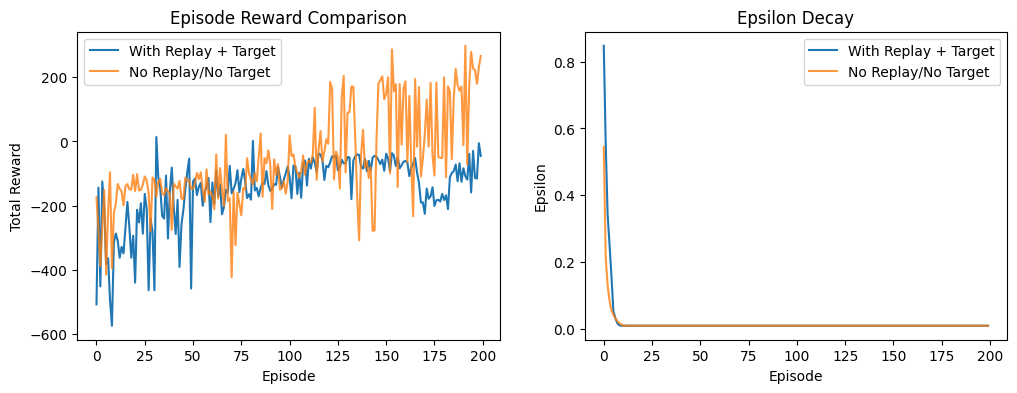

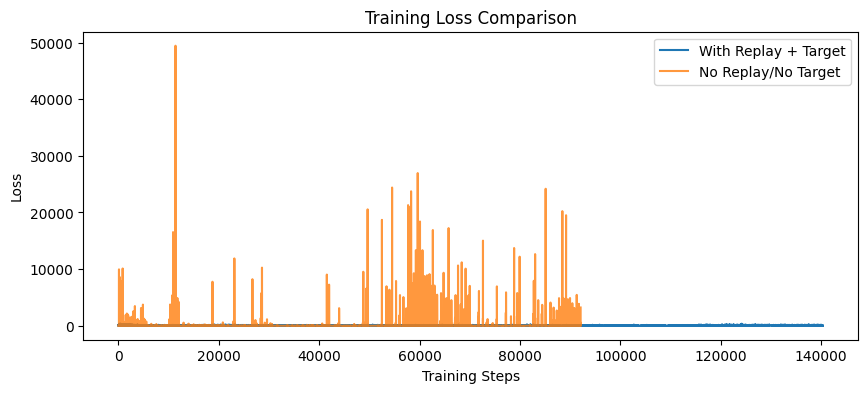

In [23]:


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(rewards, label="With Replay + Target")
plt.plot(rewards_base, label="No Replay/No Target", alpha=0.8)
plt.xlabel("Episode"); plt.ylabel("Total Reward")
plt.title("Episode Reward Comparison")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epsilons, label="With Replay + Target")
plt.plot(eps_base, label="No Replay/No Target", alpha=0.8)
plt.xlabel("Episode"); plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.legend()
plt.show()

# (Optional) Compare loss curves
if len(losses) > 0 and len(loss_base) > 0:
    plt.figure(figsize=(10,4))
    plt.plot(losses, label="With Replay + Target")
    plt.plot(loss_base, label="No Replay/No Target", alpha=0.8)
    plt.xlabel("Training Steps"); plt.ylabel("Loss")
    plt.title("Training Loss Comparison")
    plt.legend(); plt.show()
